# Point source on top  of a halfspace

To illustrate the use of the package we are going to play with the solutions
for a concentrated force located on top of a halfspace. The origin,
$\mathbf{x} = (0,0,0)$, is placed on the free surface
and positive $z$ is inside the medium. This problem is of interest when
modeling the deformation/stress around a localized load, e.g., the
load caused by the weigth of a building on top of a soil.

The derivations for the strain and stress tensors are not too difficult,
but it can get cumbersome really fast because of the lengthy calculations.
Using the package we can simplify the whole process.

In [1]:
import numpy as np
from sympy import init_printing, symbols, lambdify, S, simplify
from sympy import pi, Matrix, sqrt, oo
from continuum_mechanics.solids import sym_grad, strain_stress

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import colors

The following snippet allows to format the graphs.

In [3]:
repo = "https://raw.githubusercontent.com/nicoguaro/matplotlib_styles/master"
style = repo + "/styles/minimalist.mplstyle"
plt.style.use(style)

init_printing()

In [4]:
x, y, z, r, E, nu, Fx, Fy, Fz = symbols('x y z r E nu F_x F_y F_z')

The components of the displacement vector are given by [[1]](#References)


\begin{align}
&u_x = \frac{(1 + \nu)}{2 \pi E}  \left\{\left[\frac{xz}{r^3} - \frac{(1 - 2\nu)x}{r(r + z)}\right]F_z + 
  \frac{2(1 - \nu)r +z}{r(r + z)}F_x  +\frac{[2r(\nu r + z) + z^2]x}{r^3(r + z)^2}(xF_x + y F_y)\right\}\, ,\\
&u_y = \frac{(1 + \nu)}{2 \pi E}  \left\{\left[\frac{yz}{r^3} - \frac{(1 - 2\nu)y}{r(r + z)}\right]F_z + 
  \frac{2(1 - \nu)r +z}{r(r + z)}F_y  +\frac{[2r(\nu r + z) + z^2]y}{r^3(r + z)^2}(xF_x + y F_y)\right\}\, ,\\
&u_z = \frac{(1 + \nu)}{2 \pi E}  \left\{\left[\frac{2(1 - \nu)}{r} - \frac{z^2}{r^3}\right]F_z  +\left[\frac{1 - 2\nu}{r(r + z)} + \frac{z}{r^3}\right](xF_x +  y F_y)\right\}\, ,
\end{align}

with $r = \sqrt{x^2 + y^2 + z^2}$.

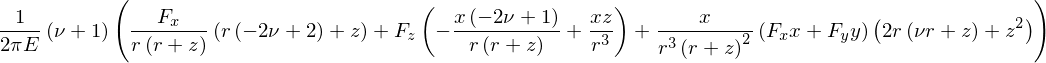

In [5]:
ux = (1+nu)/(2*pi*E)*((x*z/r**3 - (1-2*nu)*x/(r*(r + z)))*Fz +
                       (2*(1 - nu)*r + z)/(r*(r + z))*Fx +
                       ((2*r*(nu*r + z) + z**2)*x)/(r**3*(r + z)**2)*(x*Fx + y*Fy))
ux

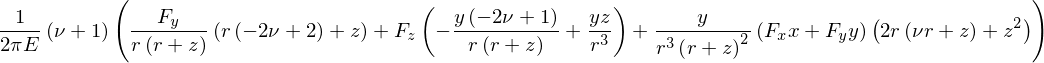

In [6]:
uy = (1+nu)/(2*pi*E)*((y*z/r**3 - (1-2*nu)*y/(r*(r + z)))*Fz +
                       (2*(1 - nu)*r + z)/(r*(r + z))*Fy +
                       ((2*r*(nu*r + z) + z**2)*y)/(r**3*(r + z)**2)*(x*Fx + y*Fy))
uy

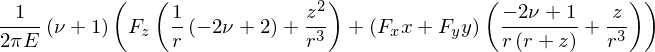

In [7]:
uz = (1+nu)/(2*pi*E)*((2*(1 - nu)/r + z**2/r**3)*Fz +
                       ((1 - 2*nu)/(r*(r + z)) + z/r**3)*(x*Fx + y*Fy))
uz

Withouth loss of generality we can assume that $F_y=0$, this is equivalent a rotate the axes until the force is in the plane $y=0$.

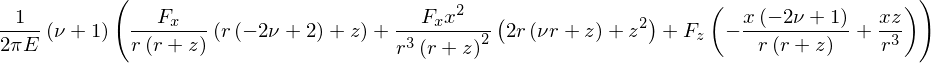

In [8]:
ux = ux.subs(Fy, 0)
ux

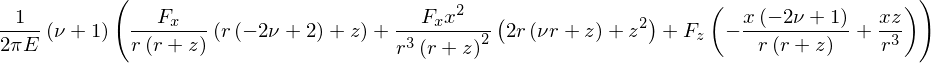

In [9]:
uy = ux.subs(Fy, 0)
uy

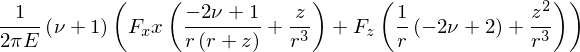

In [10]:
uz = uz.subs(Fy, 0)
uz

The displacement vector is then

In [11]:
u = Matrix([ux, uy, uz]).subs(r, sqrt(x**2 + y**2 + z**2))

We can check that the displacement vanish when $x,y,z \rightarrow \infty$

In [12]:
u.limit(x, oo)


In [13]:
u.limit(y, oo)


In [14]:
u.limit(z, oo)

We can compute the strain and stress tensors using the
symmetric gradient ([**vector.sym_grad()**](https://continuum-mechanics.readthedocs.io/en/latest/modules.html#vector.sym_grad)) and stress-to-stress ([**solids.stres_stress()**](https://continuum-mechanics.readthedocs.io/en/latest/modules.html#solids.strain_stress))
functions.

In [16]:
lamda = E*nu/((1 + nu)*(1 - 2*nu))
mu = E/(2*(1 - nu))
strain = sym_grad(u)
stress = strain_stress(strain, [lamda, mu])

The expressions for strains and stresses are lengthy and difficult to work with.
Nevertheless, we can work with them. For example, we can evaluate the stress
tensor at a point $\mathbf{x} = (1, 0, 1)$ for a vertical load and a
Poisson coefficient $\nu = 1/4$.

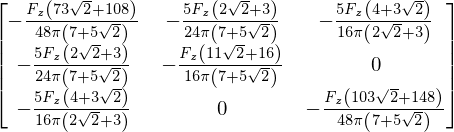

In [17]:
simplify(stress.subs({x: 1, y: 0, z:1, nu: S(1)/4, Fx: 0}))

## Visualization of the fields

Since it is difficult to handle these lengthy expressions we can
visualize them. For that, we define a grid where to evaluate the
expressions,

$$ (x, z) \in [-2, 2]\times[0, 5]\, ,$$

in this case.

In [18]:
x_vec, z_vec = np.mgrid[-2:2:100j, 0:5:100j]

We can use [**lambdify()**](https://docs.sympy.org/1.5.1/modules/utilities/lambdify.html)
to turn the SymPy expressions to evaluatable functions.

In [19]:
def field_plot(expr, x_vec, y_vec, z_vec, E_val, nu_val, Fx_val, Fz_val, title=''):
    """Plot the field""" 
    
    # Lambdify the function
    expr_fun = lambdify((x, y, z, E, nu, Fx, Fz), expr, "numpy")
    expr_vec = expr_fun(x_vec, y_vec, z_vec, E_val, nu_val, Fx_val, Fz_val) 
    
    # Determine extrema
    vmin = np.min(expr_vec)
    vmax = np.max(expr_vec)
    print("Minimum value in the domain: {:g}".format(vmin))
    print("Maximum value in the domain: {:g}".format(vmax))
    vmax = max(np.abs(vmax), np.abs(vmin))
    
    # Plotting
    fig = plt.gcf()
    levels = np.logspace(-1, np.log10(vmax), 10)
    levels = np.hstack((-levels[-1::-1], [0], levels))
    cbar_ticks = ["{:.2g}".format(level) for level in levels]
    cont = plt.contourf(x_vec, z_vec, expr_vec, levels=levels,
                        cmap="RdYlBu_r", norm=colors.SymLogNorm(0.1))
    cbar = fig.colorbar(cont, ticks=levels[::2])
    cbar.ax.set_yticklabels(cbar_ticks[::2])
    plt.axis("image")
    plt.gca().invert_yaxis()
    plt.xlabel(r"$x$")
    plt.ylabel(r"$z$")
    plt.title(title)
    return cont

### Displacements

<IPython.core.display.Javascript object>


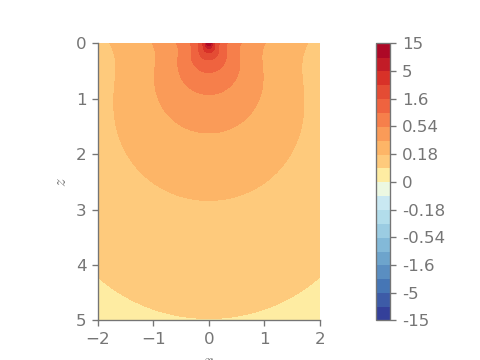

Minimum value in the domain: 0.0881197
Maximum value in the domain: 15.4645


In [20]:
plt.figure()
field_plot(u.norm(), x_vec, 0, z_vec, 1.0, 0.3, 0.0, 1.0)
plt.show()

<IPython.core.display.Javascript object>


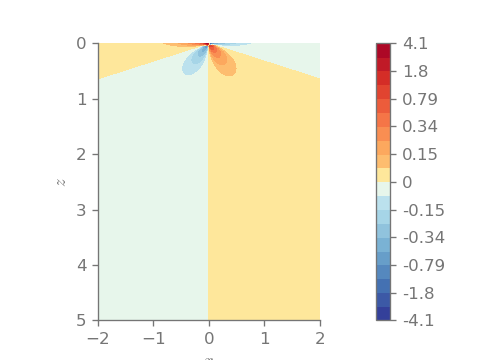

Minimum value in the domain: -4.09665
Maximum value in the domain: 4.09665


In [21]:
plt.figure()
field_plot(u[0], x_vec, 0, z_vec, 1.0, 0.3, 0.0, 1.0)
plt.show()

<IPython.core.display.Javascript object>


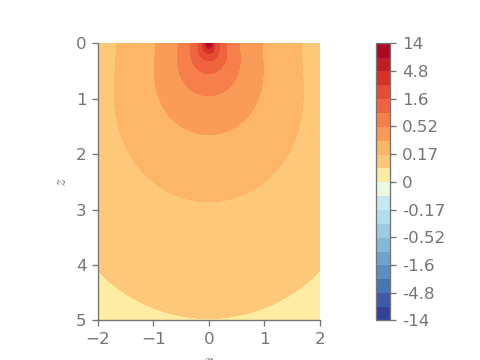

Minimum value in the domain: 0.0869101
Maximum value in the domain: 14.3383


In [22]:
plt.figure()
field_plot(u[2], x_vec, 0, z_vec, 1.0, 0.3, 0.0, 1.0)
plt.show()

### Stresses

We can plot the components of stress

<IPython.core.display.Javascript object>


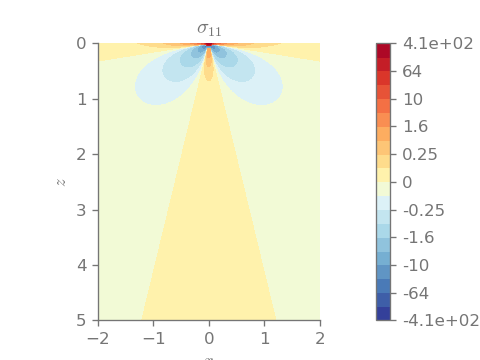

Minimum value in the domain: -41.4274
Maximum value in the domain: 406.682


<IPython.core.display.Javascript object>


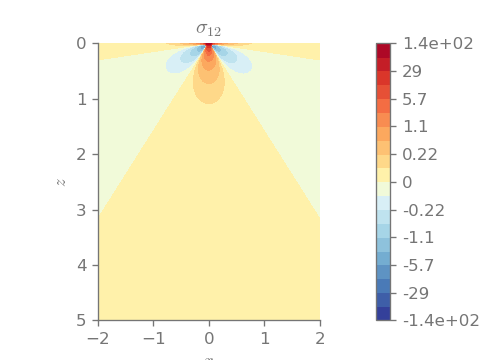

Minimum value in the domain: -12.0021
Maximum value in the domain: 144.846


<IPython.core.display.Javascript object>


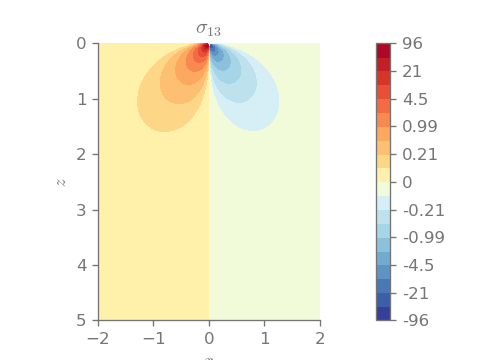

Minimum value in the domain: -95.9472
Maximum value in the domain: 95.9472


<IPython.core.display.Javascript object>


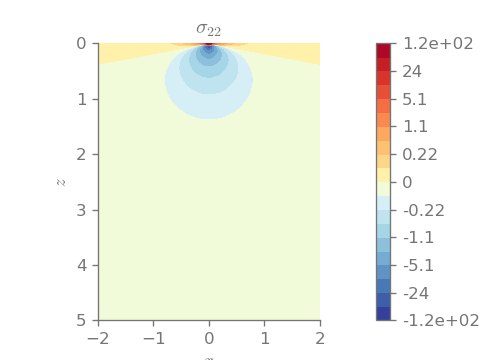

Minimum value in the domain: -59.0538
Maximum value in the domain: 116.991


<IPython.core.display.Javascript object>


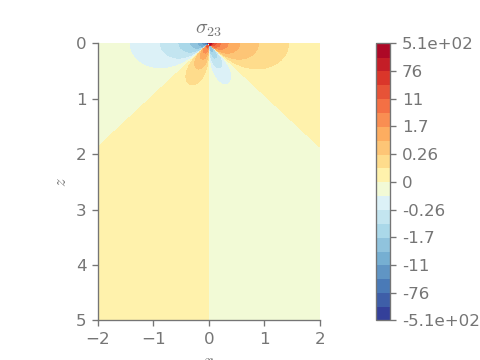

Minimum value in the domain: -506.96
Maximum value in the domain: 506.96


<IPython.core.display.Javascript object>


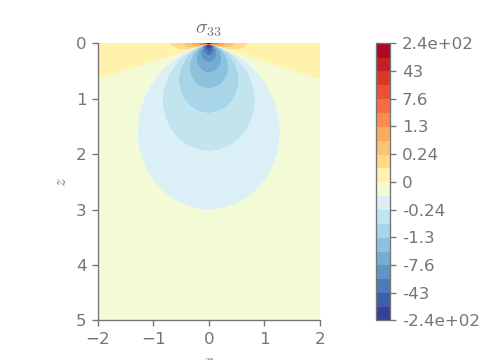

Minimum value in the domain: -243.272
Maximum value in the domain: 116.991


In [23]:
for row in range(0, 3):
    for col in range(row, 3):
        plt.figure()
        field_plot(stress[row,col], x_vec, 0, z_vec, 1.0, 0.3, 0.0, 1.0,
                   title=r"$\sigma_{%i%i}$"%(row+1, col+1))

plt.show()

### Stress invariants

We can also plot the invariants of the stress tensor

In [24]:
I1 = S(1)/3 * stress.trace()
I2 = S(1)/2 * (stress.trace()**2 + (stress**2).trace())
I3 = stress.det()
Mises = sqrt(((stress[0,0] - stress[1,1])**2 + (stress[1,1] - stress[2,2])**2 +
             (stress[2,2] - stress[0,0])**2 +
             6*(stress[0,1]**2 + stress[1,2]**2 + stress[0,2]**2))/2)

<IPython.core.display.Javascript object>


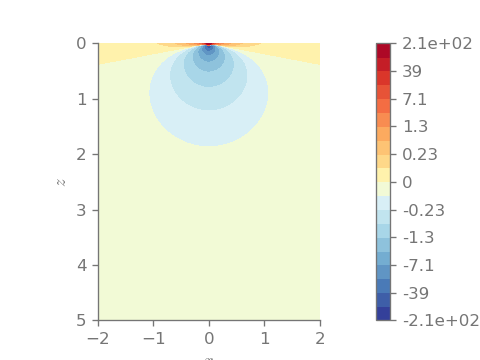

Minimum value in the domain: -107.797
Maximum value in the domain: 213.555


In [25]:
plt.figure()
field_plot(I1, x_vec, 0, z_vec, 1.0, 0.3, 0.0, 1.0)
plt.show()

<IPython.core.display.Javascript object>


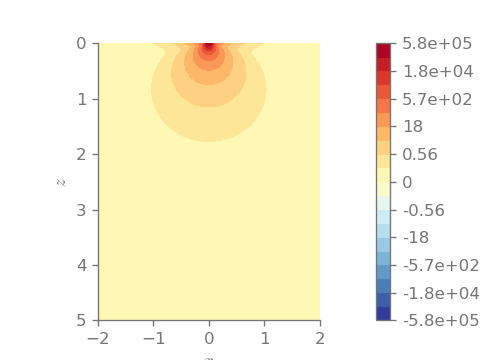

Minimum value in the domain: 0.000977492
Maximum value in the domain: 579596


In [26]:
plt.figure()
field_plot(I2, x_vec, 0, z_vec, 1.0, 0.3, 0.0, 1.0)
plt.show()

<IPython.core.display.Javascript object>


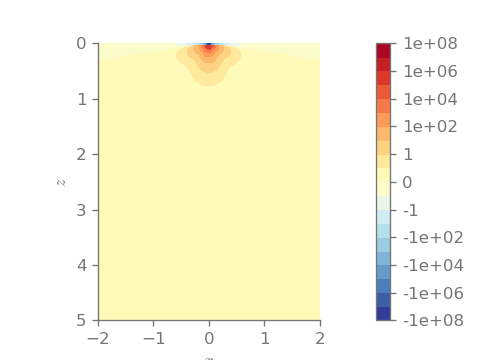

Minimum value in the domain: -1.01409e+08
Maximum value in the domain: 419218


In [27]:
plt.figure()
field_plot(I3, x_vec, 0, z_vec, 1.0, 0.3, 0.0, 1.0)
plt.show()

<IPython.core.display.Javascript object>


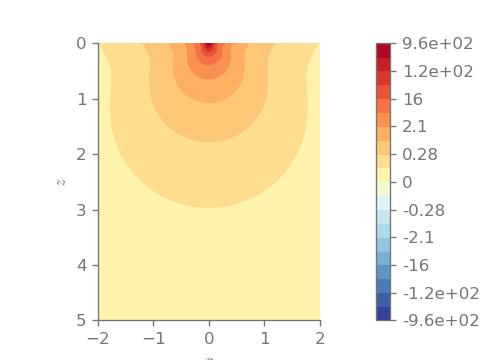

Minimum value in the domain: 0.0274784
Maximum value in the domain: 958.065


In [28]:
plt.figure()
field_plot(Mises, x_vec, 0, z_vec, 1.0, 0.3, 0.0, 1.0)
plt.show()

## References

1. Landau, L. D., Kosevich, A. M., Pitaevskii, L. P., & Lifshitz, E. M. (1986). Theory of elasticity.